### BPs in data reuploading QNNs
This notebook contains the code run to generate the plots found in Section 2.3 of the accompaining thesis. Note these trials include many repeated runs of 16 qubits circuits, and have a substantial compuational cost. The total run time for this code on a standard 2019 MacBook pro was roughly 10 hours.

In [7]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from pennylane import X, Z, I, Y

# Section 2: Numerically invistigating the conjecture that Data encoding may induce BPS

In [8]:
# Set a seed for reproducibility
np.random.seed(42)

num_qubits = 4
dev = qml.device("default.qubit", wires=num_qubits)
gate_set = [qml.RX, qml.RY, qml.RZ]

# this code implements the QNN with a simple PQC circuit and complex data encoding
def Simple_QNN(params0,params, layers=1,random_gate_sequence=None, num_qubits=None):
    local_rng = np.random.default_rng(42)
    # Generate random data using the local random generator
    data = local_rng.uniform(0, 2 * np.pi, size=(num_qubits,))
    # Apply RZ rotations and controlled RZ gates following the complex
    # data encoding shown in Figure XX
    for i in range(num_qubits):
        qml.RZ(data[i], wires=i)
    for i in range(num_qubits-1):
        qml.ctrl(qml.RZ, control=i)(data[i]*data[i+1], wires=i+1)  
    # use a simple PQC of only 1 qubit gates
    for j in range(layers):
        for i in range(num_qubits):
            if i == 0 and j ==0:
                random_gate_sequence[f"{i}_{j}"](params0, wires=i) # this parameter is defined seperatley to allow for 
            else:                                                   # to allow grad calculation
                random_gate_sequence[f"{i}_{j}"](params[i,j], wires=i)

    operators = [Z(i) for i in [0,num_qubits-1]] # local Pauli Z on each qubit
    return qml.expval(sum(operators))

In [9]:
# this code implements the simple PQC circuit with data reuploading
def DataReuploadingSimple(params0,params, layers=1,random_gate_sequence=None, num_qubits=None):
    local_rng = np.random.default_rng(42)
    # Generate random data using the local random generator
    data = local_rng.uniform(0, 2 * np.pi, size=(num_qubits,))
    
    for i in range(num_qubits):
        qml.RZ(data[i], wires=i)
    for i in range(num_qubits-1):
        qml.ctrl(qml.RZ, control=i)(data[i]*data[i+1], wires=i+1)
    for j in range(layers):
        # Data reuploading 
        for i in range(num_qubits):
            qml.RZ(data[i], wires=i)
        for i in range(num_qubits-1):
            qml.ctrl(qml.RZ, control=i)(data[i]*data[i+1], wires=i+1)
        for i in range(num_qubits):
            if i == 0 and j ==0:
                random_gate_sequence[f"{i}_{j}"](params0, wires=i) 
            else:
                random_gate_sequence[f"{i}_{j}"](params[i,j], wires=i)

    operators = [Z(i) for i in [0,num_qubits-1]]
    return qml.expval(sum(operators))

In [10]:
# run 500 trials for each number of qubits
np.random.seed(42)
num_samples = 500
qubits = [2, 3, 4, 5, 6, 8,10,12,14,16]
variances = []
means = []
gate_sequence = {}
for num_qubits in qubits:
    grad_vals = []
    grad_vals0 = []
    grad_vals2 = []
    layers= 10*num_qubits
    for i in range(num_samples):
        dev = qml.device("default.qubit", wires=num_qubits)
        qcircuit = qml.QNode(Simple_QNN, dev, interface="autograd")

        grad = qml.grad(qcircuit, argnum=[0])

        for i in range(num_qubits):
            for j in range(layers):
                gate_sequence[f"{i}_{j}"] = np.random.choice(gate_set)


        params=np.random.uniform(0, 2 * np.pi, size=(num_qubits,layers))
        gradient = grad(params[0,0],params, layers=layers,random_gate_sequence=gate_sequence, num_qubits=num_qubits)

        grad_vals.append(gradient)

    variances.append(np.var(grad_vals))
    means.append(np.mean(grad_vals))
    print(f"Number of qubits: {num_qubits}, Mean: {np.mean(grad_vals)}, Variance: {np.var(grad_vals)}")


variances = np.array(variances)

qubits = np.array(qubits)


# fit the data to a line, get the covariance matrix returned as well
slope, cov = np.polyfit(qubits, np.log2(variances), 1,cov=True )


Number of qubits: 2, Mean: -0.004232571528945711, Variance: 0.22927444605846828
Number of qubits: 3, Mean: -0.01635593410154359, Variance: 0.23284981384764328
Number of qubits: 4, Mean: 0.0007945229271967005, Variance: 0.20101202758821876
Number of qubits: 5, Mean: -0.008596300790468771, Variance: 0.2315089485919083
Number of qubits: 6, Mean: 0.001675164848170561, Variance: 0.21241734935298656
Number of qubits: 8, Mean: 0.009243818069843859, Variance: 0.21185412345150997
Number of qubits: 10, Mean: 0.0011963646373882374, Variance: 0.2231484119606013
Number of qubits: 12, Mean: 0.0339713454300312, Variance: 0.21931002181103604
Number of qubits: 14, Mean: 0.0035597191932614774, Variance: 0.2428384822926081
Number of qubits: 16, Mean: 0.019457379113937003, Variance: 0.22428097277970072


In [11]:
np.random.seed(42)
num_samples = 500
qubits = [2, 3, 4, 5, 6, 8,10,12,14,16]
RUvariances = []
RUmeans = []

for num_qubits in qubits:
    grad_vals = []

    layers= 10*num_qubits
    for i in range(num_samples):
        dev = qml.device("default.qubit", wires=num_qubits)
        qcircuit = qml.QNode(DataReuploadingSimple, dev, interface="autograd")

        grad = qml.grad(qcircuit, argnum=[0])

        for i in range(num_qubits):
            for j in range(layers):
                gate_sequence[f"{i}_{j}"] = np.random.choice(gate_set)


        params=np.random.uniform(0, 2 * np.pi, size=(num_qubits,layers))
        gradient = grad(params[0,0],params, layers=layers,random_gate_sequence=gate_sequence, num_qubits=num_qubits)

        grad_vals.append(gradient[0])

    RUvariances.append(np.var(grad_vals))
    RUmeans.append(np.mean(grad_vals))
    print(f"Number of qubits: {num_qubits}, Mean: {np.mean(grad_vals)}, Variance: {np.var(grad_vals)}")


RUvariances = np.array(RUvariances)

qubits = np.array(qubits)


# fit the data to a line
RUslope,RUcov = np.polyfit(qubits, np.log2(RUvariances), 1,cov=True)

Number of qubits: 2, Mean: 0.0011438760678731202, Variance: 0.17433468557918558
Number of qubits: 3, Mean: -0.0028699027660484496, Variance: 0.09202012925698595
Number of qubits: 4, Mean: 0.006321321933671044, Variance: 0.04859679870636434
Number of qubits: 5, Mean: -0.011561179796503793, Variance: 0.02390271844623372
Number of qubits: 6, Mean: -0.014272938710679188, Variance: 0.014746012838982766
Number of qubits: 8, Mean: 0.0015695436489429966, Variance: 0.003498320261678221
Number of qubits: 10, Mean: -0.002153972201580584, Variance: 0.00121624081389589
Number of qubits: 12, Mean: 0.00023907950927523557, Variance: 0.00039281055054450403
Number of qubits: 14, Mean: 1.7320087510740516e-05, Variance: 0.0001985884127885612
Number of qubits: 16, Mean: 0.0002067210825113063, Variance: 0.00011083324521214092


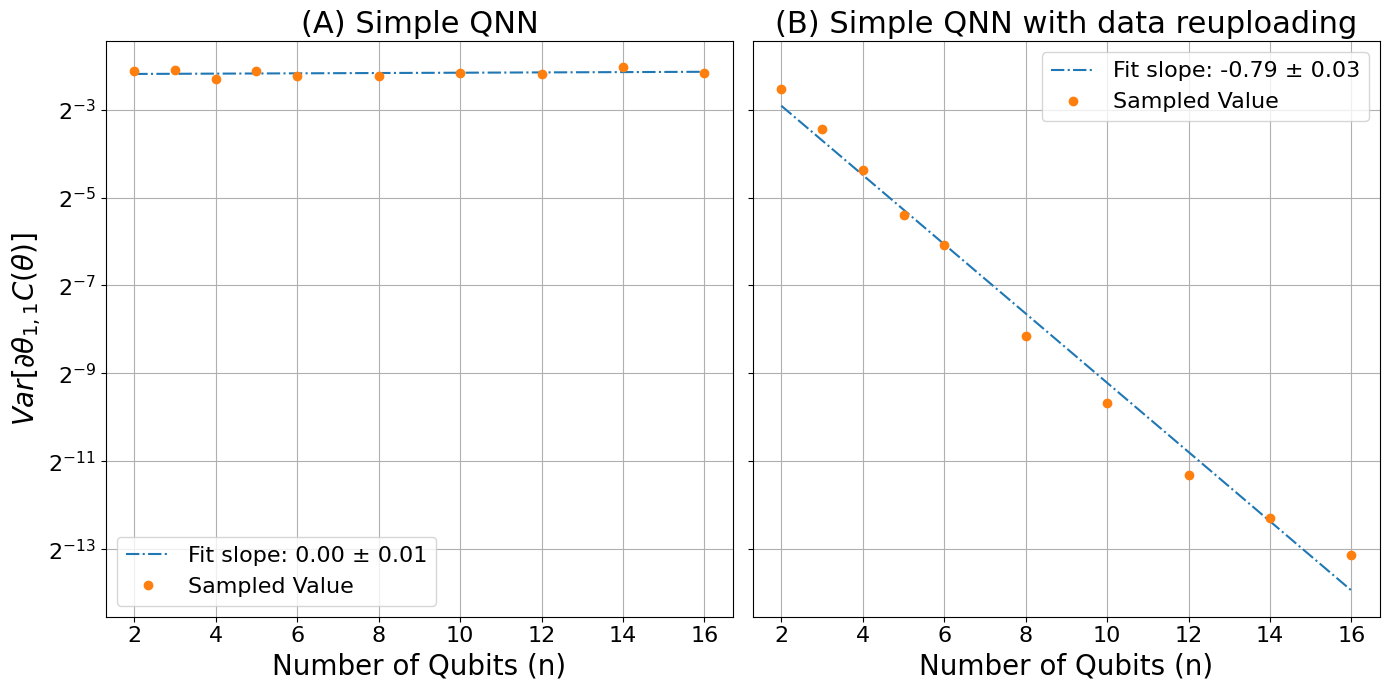

In [12]:
# Creating the figure with 2 subplots
plt.rcParams.update({'axes.labelsize': 20,  # Axis labels
                     'xtick.labelsize': 16,  # X-axis tick labels
                     'ytick.labelsize': 16,  # Y-axis tick labels
                     'legend.fontsize': 16,  # Legend font size
                     'axes.titlesize': 22})  # Titles size

fig, axs = plt.subplots(1, 2, figsize=(14, 7),sharey=True)
qubits = np.array([2, 3, 4, 5, 6, 8,10,12,14,16])
# First subplot: simple QNN
axs[0].plot(qubits, 2**(slope[0] * qubits + slope[1]), "-.", label="Fit slope: {:3.2f} ± {:3.2f}".format(slope[0], np.sqrt(cov[0,0])))
axs[0].plot(qubits, variances, "o", label="Sampled Value")
axs[0].set_xlabel(r"Number of Qubits (n)")
axs[0].set_ylabel(r"$Var[\partial \theta_{1, 1} C(\theta)]$")
axs[0].set_title("(A) Simple QNN")
axs[0].legend()
axs[0].grid(True)
axs[0].set_yscale('log', base=2)

# Second subplot: Standard HEA Circuit
axs[1].plot(qubits, 2**(RUslope[0] * qubits + RUslope[1]), "-.", label="Fit slope: {:3.2f} ± {:3.2f}".format(RUslope[0], np.sqrt(RUcov[0,0])))
axs[1].plot(qubits, RUvariances, "o", label="Sampled Value")
axs[1].set_xlabel(r"Number of Qubits (n)")
axs[1].set_title("(B) Simple QNN with data reuploading")
axs[1].legend()
axs[1].grid(True)
axs[1].set_yscale('log', base=2)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

## Code for the plot in Appendix A2:
Dmeonstrates that the observed BP is caused from the expressibility of the circuit, rather than the locality of the cost function. To do this the standard HEA circuit used in the first trial is rerun but at shallow depths. 

In [13]:
# this function defines the HEA circuit as given by Figure 2.7 (A)
def HEA_circuit(params0,params, layers=1,random_gate_sequence=None, num_qubits=None):
    local_rng = np.random.default_rng(42)
    # Generate random data using the local random generator
    data = local_rng.uniform(0, 2 * np.pi, size=(num_qubits,))

    for i in range(num_qubits):
        qml.RY(data[i], wires=i) # data encoding layer using simple angle encoding
    for j in range(layers):      # HEA circuit
        for i in range(num_qubits): # pauli rotation on each qubit 
            if i == 0 and j ==0:
                random_gate_sequence[f"{i}_{j}"](params0, wires=i) # the first param is defined seperatley to allow for 
            else:                                                  # the gradient to be calculated
                random_gate_sequence[f"{i}_{j}"](params[i,j], wires=i)

        for i in range(num_qubits - 1):
            qml.CZ(wires=[i, i + 1]) # Entangling through control z gates between neighbouring qubit

    operators = [Z(i) for i in [0,num_qubits-1]] # local pauli z operator on each qubit
    return qml.expval(sum(operators))

In [17]:
np.random.seed(42)
num_samples = 500  # sample 500 random circuits
# every second qubit at higher counts to save computatuion time
qubits = [2, 3, 4, 5, 6, 8,10,12,14,16]

Shallow_variances = []
Shallow_mean = []

gate_sequence = {}
for num_qubits in qubits:
    grad_vals = []
    layers= int(np.log(num_qubits))+1    # set the layers to scale as log, hence according to Cerezo et al. "Cost function dependent barren plateaus in shallow parametrized quantum circuits"
    for i in range(num_samples):         # this trial should not experience the BP
        dev = qml.device("default.qubit", wires=num_qubits)
        qcircuit = qml.QNode(HEA_circuit, dev, interface="autograd") # set up pennylane circuit

        grad = qml.grad(qcircuit, argnum=[0]) # specify taking the gradeint with respect to the first parameter

        for i in range(num_qubits):
            for j in range(layers):
                gate_sequence[f"{i}_{j}"] = np.random.choice(gate_set)

        params=np.random.uniform(0, 2 * np.pi, size=(num_qubits,layers))
        gradient = grad(params[0,0],params, layers=layers,random_gate_sequence=gate_sequence, num_qubits=num_qubits)
        grad_vals.append(gradient)
    Shallow_variances.append(np.var(grad_vals))
    Shallow_mean.append(np.mean(grad_vals))
    print(f"Number of qubits: {num_qubits}, Mean: {np.mean(grad_vals)}, Variance: {np.var(grad_vals)}")

Shallow_variances = np.array(Shallow_variances)


qubits = np.array(qubits)



# fit the data to a line log2
Shallow_slope , shallowcov = np.polyfit(qubits, np.log2(Shallow_variances), 1,cov=True)

Number of qubits: 2, Mean: -0.012227892582792735, Variance: 0.1811909177227655
Number of qubits: 3, Mean: 0.008882580605891529, Variance: 0.1484938049528768
Number of qubits: 4, Mean: -0.001682593400386728, Variance: 0.15512635299882296
Number of qubits: 5, Mean: -0.040265755637696646, Variance: 0.1653562359102376
Number of qubits: 6, Mean: 0.002624861998179388, Variance: 0.1887716454611636
Number of qubits: 8, Mean: -0.006150484241821083, Variance: 0.15854768975534736
Number of qubits: 10, Mean: 0.023503809340915765, Variance: 0.13457256345540708
Number of qubits: 12, Mean: -0.00579766596099125, Variance: 0.1554422531231421
Number of qubits: 14, Mean: -0.005905692667859123, Variance: 0.16840238386406026
Number of qubits: 16, Mean: 0.018523458235711717, Variance: 0.16192471309320064


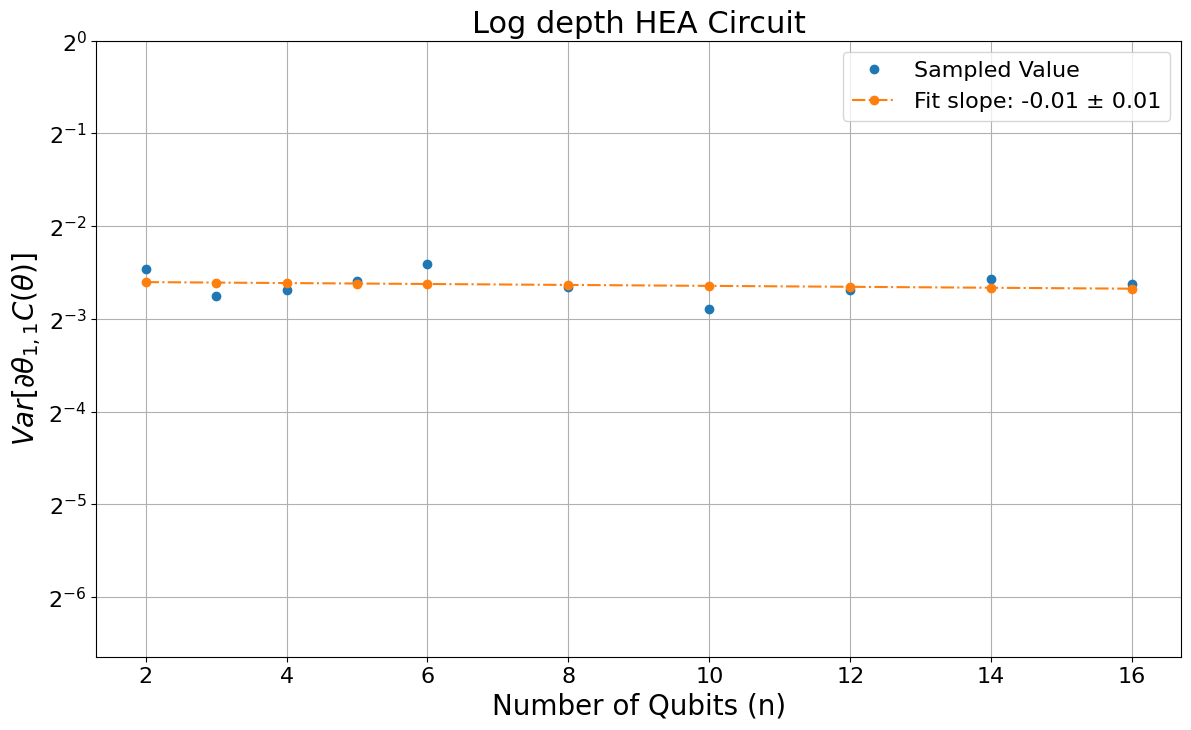

In [20]:
plt.figure(figsize=(14, 8))

plt.plot(qubits, Shallow_variances, "o", label="Sampled Value")
#plt.plot(qubits,np.abs(means), "o")
plt.plot(qubits, 2**(Shallow_slope[0] * qubits + Shallow_slope[1]), "o-.", label = "Fit slope: {:3.2f} ± {:3.2f}".format(Shallow_slope[0], np.sqrt(shallowcov[0,0])))
plt.xlabel(r"Number of Qubits (n)")
plt.ylabel(r"$Var[\partial \theta_{1, 1} C(\theta)]$")
plt.title("Log depth HEA Circuit")
plt.legend()
plt.grid()
plt.ylim(0.01,1)
plt.yscale('log', base=2)
plt.show()